Consider the following population model.  

$$dx/dt= \alpha_1 x(1-x/K)-\beta x y$$
$$dy/dt=\alpha_2 y+3\beta x y$$

1. (by hand) Identify the variables and parameters.  Explain each piece of these equations:  Which expressions account for exponential growth?  Logistic growth? Coupling between species?  Which variable represents the prey?  Which variable represents the predator?  What does each parameter represent?  (See Section 6.1 of Buzby and Lee, equations 6.1 and 6.2.)  Choose a particular species for $x$ and $y$, e.g. rats and owls.

2. (by hand) Find the Jacobian matrix.  (See Section 6.5 of Buzby and Lee.)

3. (by hand) Find the equilibria.  (These will be in terms of $\alpha_1$, $\alpha_2$, $K$, and $\beta$.  You do not need to plug in the equilibria to the Jacobian yet.)

Written as a system of difference equations, this model becomes 
$$x_{n+1}=x_n+\alpha_1 x_n(1-x_n/K)-\beta x_n y_n$$
$$y_{n+1}=y_n+\alpha_2 y_n+3\beta x_n y_n$$

4.  Write code that simulates this model.  Play with the parameters and initial conditions.  Graph the populations of the two species against time.  Also graph a phase plane diagram.  (You can use the code from HW 8.)  Settle on parameters and initial conditions that feel reasonable.

5.  (by hand, or in Python) Evaluate your expressions for the equilibria using the parameter values you chose.  Classify the equilibria by finding eigenvalues of the Jacobian.  (See Theorem 6.5.1 of Buzby and Lee.)

6.  Write code that allows $\beta$ (or a parameter of your choosing) to vary stochastically.  (So, at each time step, $\beta$ should be determined by sampling a random variable; see the Chapter 7 probability distribution sampling examples we did.)  Justify your choice of probability distribution.  Why might $\beta$ (or your parameter of choice) follow this probability distribution?  (Think about what the parameter represents in the model.)  Again make two graphs:  one showing the two species varying over time, the other a phase plane diagram. 

7.  What are the limitations of this model?  How could it be improved? 

In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *


# import libraries
# (these may or may not be necessary)

import matplotlib.pyplot as plt

import numpy as np
from numpy.linalg import eig

from scipy.stats import norm

In [2]:
def make_system(K, beta, alpha1, alpha2, prey0, predator0):
    """Make a system object for the Predator-Prey model.
    
    returns: System object
    """
    init = State(X=prey0, Y=predator0)
#    init /= sum(init)  # if you want fractions of population

    t0 = 0
    t_end = 52*10 
    # 52-week simulation, 10 years

    return System(init=init, t0=t0, t_end=t_end,
                  K=K, beta=beta, alpha1=alpha1, alpha2=alpha2)

In [3]:
def update_func(state, t, system):
    """Update the Predator-Prey model.
    
    state: State with variables X, Y
    t: time step
    system: System with parameters and initial conditions
    
    returns: State object
    """
    x, y = state
    
    prey = system.alpha1*x*(1-x/system.K)-system.beta*x*y
    predator = system.alpha2*y+3*system.beta*x*y
    
    # total number of predators and prey gained or lost in a time step
    
    x += prey 
    y += predator
    # using '+=, but could really be subtracting, if 'predator' or 'prey' is negative 
    
    return State(X=x, Y=y)

In [4]:
def plot_results(X, Y):
    """Plot the results of the Predator-Prey model.
    
    X: TimeSeries
    Y: TimeSeries
    """
    plot(X, '--', label='Prey')
    plot(Y, ':', label='Predators')
    decorate(xlabel='Time (Week)',
             ylabel='population Density')

In [5]:
def run_simulation(system, update_func):
    """Runs a simulation of the system.
        
    system: System object
    update_func: function that updates state
    
    returns: TimeFrame
    """
    frame = TimeFrame(columns=system.init.index)
    frame.row[system.t0] = system.init
    
    for t in linrange(system.t0, system.t_end):
        frame.row[t+1] = update_func(frame.row[t], t, system)
    
    return frame

In [6]:
alpha1=.5
alpha2=-.5
beta = .050
K=7
prey0=.10
predator0=.6
#alpha1=.2
#alpha2=-.2
#beta = .0455 # this is approximately the value of beta that leads to perfectly oscillatory behavior, 
# at least for these choices of alpha1, alpha2, and K
# make it slightly smaller for stable behavior, or slightly larger for unstable behavior
#K=10
#prey0=.5
#predator0=.2

system = make_system(K, beta, alpha1, alpha2, prey0, predator0)
results = run_simulation(system, update_func)
results.head()

,X,Y
0,0.100000,0.600000
1,0.146286,0.309000
2,0.215640,0.161280
3,0.318399,0.085857
4,0.468991,0.047029


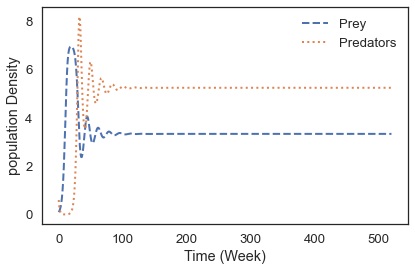

In [7]:
plot_results(results.X, results.Y) 

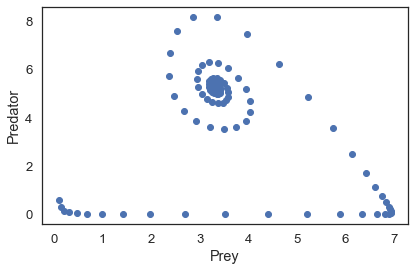

In [8]:
# phase-plane diagram showing a trajectory 

plot(results.X, results.Y, linestyle='none', marker='o')
decorate(xlabel='Prey',
             ylabel='Predator')

In [9]:
# these Jacobian values were worked out by hand

x1=0
y1=0

x2=-alpha2/(3*beta)
y2=alpha1*(1+alpha2/(3*beta*K))/beta

J1 = np.array([[alpha1-2*alpha1*x1/K-beta*y1, -beta*x1 ], 
              [3*beta*y1,   alpha2+3*beta*x1]])
w1,v1=eig(J1)
print('Eigenvalues of Jacobian at (0,0):', w1)

J2 = np.array([[alpha1-2*alpha1*x2/K-beta*y2, -beta*x2 ], 
              [3*beta*y2,   alpha2+3*beta*x2]])
w2,v2=eig(J2)
print('Eigenvalues of Jacobian at second equilibrium', w2)

print('second equilibrium:', x2, y2)

Eigenvalues of Jacobian at (0,0): [ 0.5 -0.5]
Eigenvalues of Jacobian at second equilibrium [-0.11904762+0.34173095j -0.11904762-0.34173095j]
second equilibrium: 3.333333333333333 5.238095238095239


In [10]:
# now to vary one of the parameters stochastically

def update_func_beta_normal(state, t, system):

    x, y = state
    stochastic_beta = np.random.normal(loc=system.beta, scale=.01) #here's the stochastic part
    
    prey = system.alpha1*x*(1-x/system.K)-stochastic_beta*x*y
    predator = system.alpha2*y+3*stochastic_beta*x*y
    
    
    x += prey 
    y += predator
    
    return State(X=x, Y=y)

In [11]:
def run_simulation_beta_normal(system, update_func_beta_normal):
    
    frame = TimeFrame(columns=system.init.index)
    frame.row[system.t0] = system.init
    
    for t in linrange(system.t0, system.t_end):
        frame.row[t+1] = update_func_beta_normal(frame.row[t], t, system)
    
    return frame

In [12]:
alpha1=.5
alpha2=-.5
beta = .050
K=7
prey0=.10
predator0=.6

system = make_system(K, beta, alpha1, alpha2, prey0, predator0)
results = run_simulation(system, update_func_beta_normal)
results.head()

,X,Y
0,0.100000,0.600000
1,0.146288,0.308993
2,0.215534,0.161606
3,0.318508,0.085228
4,0.469179,0.046621


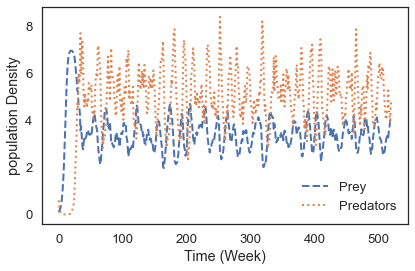

In [13]:
plot_results(results.X, results.Y) 

(0.0, 100.0)

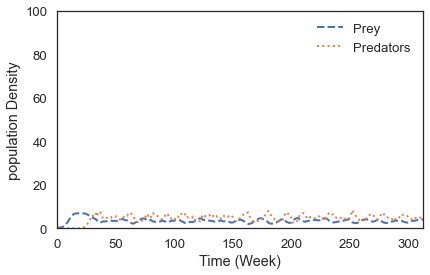

In [14]:
# if your plot above extremely large numbers on the y-axis (e.g. 1e300), zoom in to see what happened.
plot_results(results.X, results.Y) 
plt.xlim([0, 52*6])
plt.ylim([0, 100])
# hmm --- looks like one week, the stochastic variation in beta caused the predator population to shoot up! 
# see how sensitive this system is to random small changes?

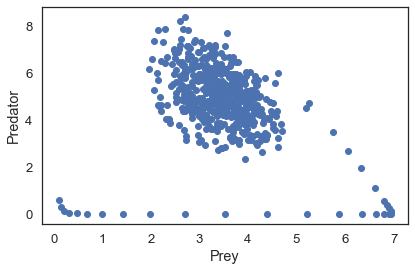

In [15]:
# phase-plane diagram showing a trajectory

plot(results.X, results.Y, linestyle='none', marker='o')
decorate(xlabel='Prey',
             ylabel='Predator')

# again, you might need to zoom in to see what happened, but you don't have to.  

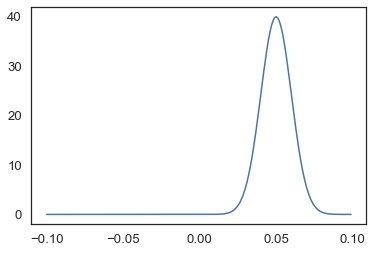

In [16]:
# this is the probability distribution that your stochastic beta follows:  normal, with mean beta, and standard deviation .01

#x-axis ranges from -3 and 3 with .001 steps
x = np.arange(-.1, .1, 0.001)

#plot normal distribution with mean 0 and standard deviation 1
plt.plot(x, norm.pdf(x, beta, .01))

In [18]:
np.random.normal(loc=beta, scale=.01) # this is what your stochastic beta is at each time step; it changes every time

0.055671223226369235

In [ ]:
#limitations to model: model does not depict the predators hunting style. It also does not depict the entire ecology of 
#the entire system.

#It could probably be improved by using poisson distribution to depict more of an ambush hunting style. 
